In [17]:
import os
import glob
from functools import reduce

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

## Configurations

```json
{
    "vms": {
        "base_vm_id": 105,
        "clients": [110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
        "type-unused": "NAT",
        "type": {
            "DR": {
                "prefix": "172.17.60.0/24",
                "iface": "eth1"
            }
        }
    },
    "httperf": {
        "vip": "172.17.60.201",
        "port": 80,
        "num-conns": 2000,
        "num-calls": 1,
        "rate": 20,
        "ramp": 20,
        "iters": 50,
        "timeout": 1
    }
}
```

In [19]:
run_name = "current/httperf_unbalance_wrr_to1_fdb_percentiles"

## Client side stats

In [20]:
# read in the data
plot_data_list = []

for i in glob.glob("./results/" + run_name + "/httperf_client_*.csv"):
    plot_data_list.append(pd.read_csv(i, header=0, na_filter=False))

In [21]:
plot_data = pd.DataFrame()

if len(plot_data_list) > 0:
    for i in list(plot_data_list[0]):
        if not i.startswith('Response time'):
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] for j in range(len(plot_data_list))])
        else:
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] 
                                                       for j in range(len(plot_data_list))]) / len(plot_data_list)

plot_data.head()

,Response time 66%,Response status 4xx,Response rate 99%,Response time 50%,Response time 99%,Response rate 66%,Response rate 75%,Response time,Number of requests,Response rate 90%,...,Response rate 98%,Response time 98%,Request rate,Response time 90%,Response status 5xx,Response status 2xx,Response time 80%,Response rate 50%,Rate,Response rate 95%
0,1.0000,0,320.0,1.0000,16.4375,304.0,304.0,2.73750,32000,315.0,...,319.0,13.8750,319.9,8.5625,0,32000,3.5625,304.0,320,318.0
1,1.0000,0,693.0,1.0000,220.8125,624.0,626.0,14.73125,32000,649.0,...,693.0,158.9375,640.0,40.7500,0,31995,4.6875,624.0,640,663.0
2,2.7500,0,1131.0,1.0625,963.8125,938.0,947.0,44.51875,31811,993.0,...,1131.0,860.0000,926.3,9.0625,0,29749,4.9375,882.0,960,1050.0
3,3.6875,0,1330.0,1.9375,521.8125,1262.0,1263.0,17.21875,31566,1279.0,...,1330.0,233.6875,1246.5,8.9375,0,30384,5.8125,1239.0,1280,1303.0
4,4.1875,0,1704.0,2.6250,514.3750,1587.0,1597.0,18.26250,32000,1624.0,...,1704.0,360.1250,1581.8,10.3750,0,31822,6.8125,1581.0,1600,1656.0


### 1. Request rate

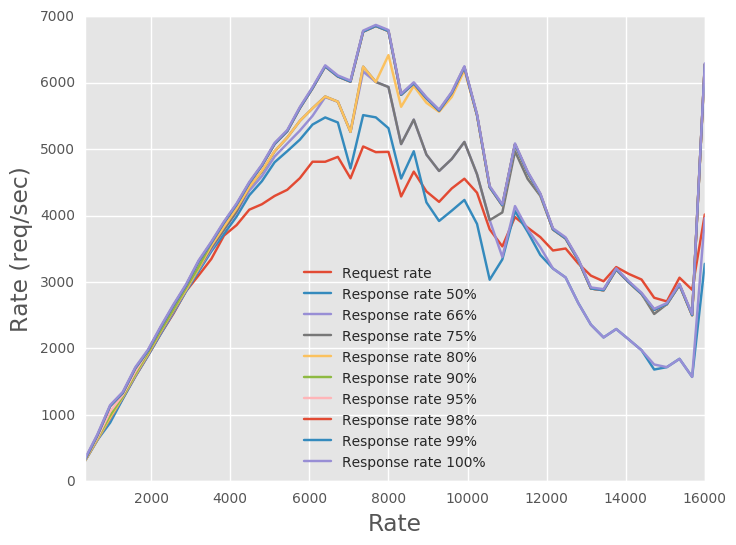

In [22]:
plot_data.plot('Rate', ['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%',
                        'Response rate 80%', 'Response rate 90%', 'Response rate 95%', 'Response rate 98%',
                        'Response rate 99%', 'Response rate 100%'], ylim=(0, None)).set_ylabel("Rate (req/sec)")

In [23]:
plot_data['Rate'].describe()

count       50.000000
mean      8160.000000
std       4664.761516
min        320.000000
25%       4240.000000
50%       8160.000000
75%      12080.000000
max      16000.000000
Name: Rate, dtype: float64

In [24]:
plot_data['Request rate'].describe()

count      50.000000
mean     3491.716000
std      1154.126216
min       319.900000
25%      3018.250000
50%      3688.000000
75%      4359.300000
max      5041.100000
Name: Request rate, dtype: float64

In [25]:
plot_data['Response rate 95%'].describe()

count      50.000000
mean     4113.120000
std      1731.544629
min       318.000000
25%      2883.500000
50%      4161.000000
75%      5730.250000
max      6855.000000
Name: Response rate 95%, dtype: float64

### 2. Response time

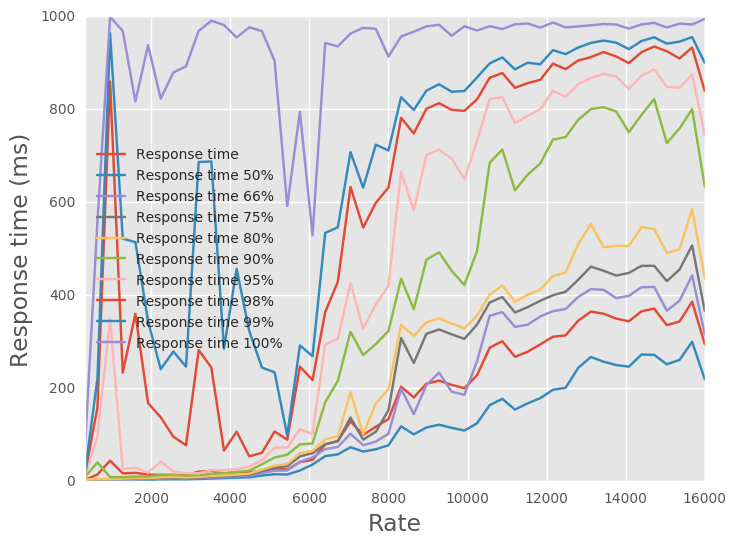

In [26]:
plot_data.plot('Rate', ['Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%',
                        'Response time 80%', 'Response time 90%', 'Response time 95%', 'Response time 98%',
                        'Response time 99%', 'Response time 100%'], ylim=(0, None)).set_ylabel("Response time (ms)")

In [27]:
plot_data['Response time'].describe()

count     50.000000
mean     168.493125
std      137.864279
min        2.737500
25%       22.389062
50%      157.162500
75%      299.712500
max      386.287500
Name: Response time, dtype: float64

In [28]:
plot_data['Response time 95%'].describe()

count     50.000000
mean     461.853750
std      354.101770
min       10.875000
25%       52.328125
50%      504.375000
75%      825.109375
max      885.812500
Name: Response time 95%, dtype: float64

### 3. Success rate

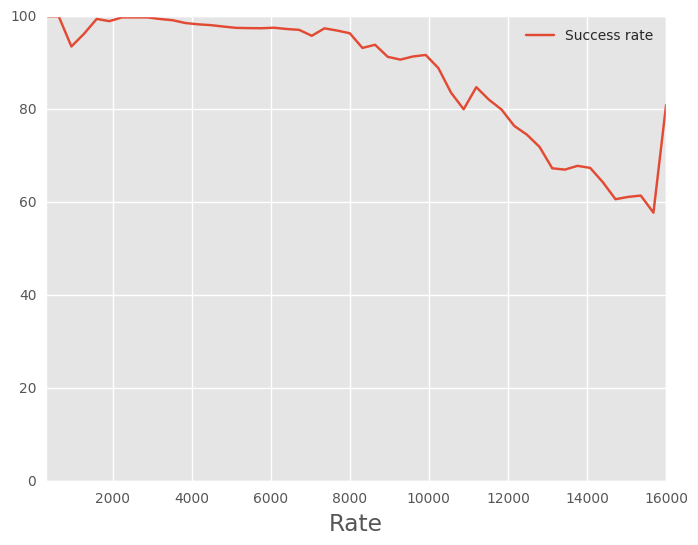

In [29]:
plot_data['Success rate'] = (plot_data['Response status 2xx'] + plot_data['Response status 3xx']) / plot_data['Number of requests'] * 100.0
plot_data.plot('Rate', 'Success rate', ylim=(0, None))

In [30]:
plot_data['Success rate'].describe()

count     50.000000
mean      87.600173
std       13.408543
min       57.776530
25%       79.956550
50%       93.700016
75%       97.744039
max      100.000000
Name: Success rate, dtype: float64

## Server side stats

In [31]:
# read in the stats data
stats_data = pd.read_csv("./results/" + run_name + "/httperf_server_stats.csv", header=0, na_filter=False)
stats_data['Connections Ratio (%)'] = stats_data['Connections'] / sum(stats_data['Connections']) * 100
stats_data['Packets Ratio (%)'] = stats_data['Packets'] / sum(stats_data['Packets']) * 100
stats_data['Bytes Ratio (%)'] = stats_data['Bytes (K)'] / sum(stats_data['Bytes (K)']) * 100
stats_data

,Server,Connections,Packets,Bytes (K),Connections Ratio (%),Packets Ratio (%),Bytes Ratio (%)
0,11.11.11.107:80,6350,385353,25380.088,10.216230,5.874372,5.785979
1,11.11.11.106:80,19553,2176308,145630.000,31.457945,33.175928,33.199734
2,11.11.11.103:80,18237,2017398,135076.000,29.340691,30.753482,30.793705
3,11.11.11.102:80,18016,1980842,132562.000,28.985134,30.196218,30.220581
